# Simple Linear Models WITH HHS DATA

In [1]:
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
data_dir = './vaccine_data/hhs_data/'

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

In [3]:
train_years = ['2013','2014']
dev_years = ['2015']
test_years = ['2016','2017']

train_download_dir = ('train',train_years)
dev_download_dir = ('dev',dev_years)
test_download_dir = ('test',test_years)
data_split_ls = [train_download_dir,dev_download_dir,test_download_dir]

## Plotting percentage trends year on year dev

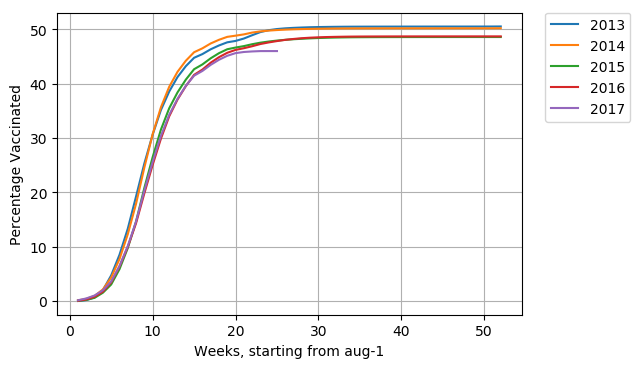

In [4]:
fig=plt.figure( dpi= 100)

for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))
        data['percentage']=data['percentage']
        # data = data[['week','count','percentage','disparity','week_start']]
        plt.plot(data['week'],100*data['percentage'],label=year);
        
plt.grid()     
plt.xlabel('Weeks, starting from aug-1')
plt.ylabel('Percentage Vaccinated')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Plotting count trends year on year dev

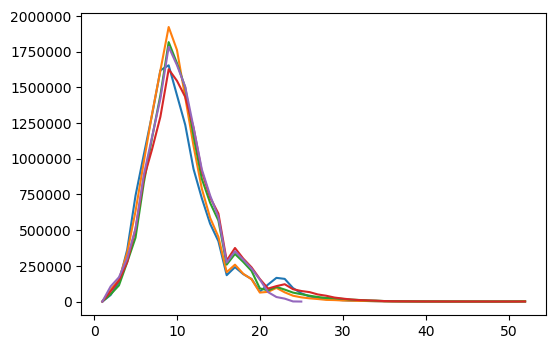

In [5]:
fig=plt.figure( dpi= 100)

for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))
        data['percentage']=data['percentage']
        # data = data[['week','count','percentage','disparity','week_start']]
        count_vaccinated_week = (data['percentage']*data['count']).values
        count_vaccinated_week[1:]=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
        count_vaccinated_week[0]=0
        plt.plot(data['week'],count_vaccinated_week,label=year);
        
# plt.grid()     
# plt.xlabel('Weeks, starting from aug-1')
# plt.ylabel('People Vaccinated')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.show()

In [6]:
# removing test
data_split_ls = [train_download_dir,dev_download_dir]

In [7]:
data_split_ls

[('train', ['2013', '2014']), ('dev', ['2015'])]

##  Predicting Percentage 
###  Predicting week n+p based on week n,n-1,n-2 ... n-k without padding


In [8]:
p_list = [i  for i in range(1,8)]
k_list = [i for i in range(1,15)]
error_year_dict = {}
model_year_dict = {}
for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        error_mat = [[-1]*len(k_list) for i in range(len(p_list))]
        model_mat = [[-1]*len(k_list) for i in range(len(p_list))]

        for p in p_list:
            for k in k_list :           
                data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))

                count_vaccinated_week = (data['percentage']).values
                count_vaccinated_week=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
                # count_vaccinated_week = [i for i in range(0,52)]
                Y = []
                X = []
                for i in range(k,len(count_vaccinated_week)-p):
                    x_col = []
                    for j in range(i-k,i):
                        x_col.append(count_vaccinated_week[j])
                    X.append(x_col)
                    Y.append(count_vaccinated_week[i+p-1])
                # sanity checks
#                 print('X[0]',X[0])
#                 print('Y first target',[Y[0]])

                assert(len(Y)==len(X))

                model = linear_model.LinearRegression()
                model.fit(X,Y)
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred,Y)
                error_mat[p-1][k-1]=error*data['count'][0]
                model_mat[p-1][k-1]=(model.coef_,model.intercept_)
#                 print('error mat',error_mat)
#                 print("-"*50)
#                 print("K = {} and P = {}".format(k,p))
#                 print("National Data Split:{} Year:{}".format(split, year))
#                 print("-"*50)
#                 print('Model coefficents {}, Model Bias {}'.format(model.coef_,model.intercept_))
#                 print('error',error)
#                 print("\n")
               
        error_year_dict[year] = error_mat
        model_year_dict[year] = model_mat

In [9]:
#" Model Matrix"
print(model_year_dict['2013'][4][4])

#"Error Matrix"
# columns is k (previous weeks taken into account)
# row is week in future
# error_year_dict.keys()
# error_year_dict
pd.DataFrame(error_year_dict['2013'])


(array([ 0.5543562 , -0.47723529, -0.6743998 , -0.03776733,  1.103522  ]), 0.00020680258247645668)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,598.343461,202.244047,187.750829,146.934734,145.511725,111.302336,54.186885,35.665010,30.903637,15.869231,15.408894,14.645393,13.681935,8.081575
1,2064.375862,750.943954,596.234612,460.208586,388.945409,207.418225,69.981623,42.038926,20.177729,18.480342,17.008049,15.665421,8.537263,5.775956
2,3928.380085,1597.315675,1218.622139,809.996242,531.868415,202.243089,63.836698,22.337528,19.120359,17.217643,15.904504,8.538586,5.800624,2.559958
3,5529.078559,2503.271272,1721.418403,875.378731,433.980852,142.028699,24.413757,19.120630,17.547771,17.569060,10.054928,6.321849,3.421066,2.365592
4,6483.881995,3319.515572,1878.062689,752.352199,359.394378,115.514871,44.741993,28.413947,25.441973,10.060090,6.525668,4.136144,2.823926,1.362074
5,6496.708737,3167.415177,1471.862586,559.708990,244.881552,95.548292,34.946876,26.290187,10.194098,6.530928,4.338801,3.229197,1.446237,1.086660
6,5389.239879,2509.514996,1140.580131,406.171963,206.072609,71.420941,31.633394,10.209993,6.892316,4.340435,3.311061,1.446237,1.110759,0.701926


### Train Predicting week n+p based on week n,n-1,n-2 ... n-k without padding

In [10]:
p_list = [i  for i in range(1,8)]
k_list = [i for i in range(1,15)]
error_year_dict = {}
model_year_dict = {}
for data_split in data_split_ls:
    split,years = data_split
    for year in years:
        error_mat = [[-1]*len(k_list) for i in range(len(p_list))]
        model_mat = [[-1]*len(k_list) for i in range(len(p_list))]
        for p in p_list:
            for k in k_list :           
                data = pd.read_json(open(os.path.join(data_dir,split,year,'national.json')))

                count_vaccinated_week = (data['count']*data['percentage']).values
                count_vaccinated_week=count_vaccinated_week[1:]- count_vaccinated_week[0:-1]
                # count_vaccinated_week = [i for i in range(0,52)]
                Y = []
                X = []
                for i in range(k,len(count_vaccinated_week)-p):
                    x_col = []
                    for j in range(i-k,i):
                        x_col.append(count_vaccinated_week[j])
                    X.append(x_col)
                    Y.append(count_vaccinated_week[i+p-1])
                # sanity checks
#                 print('X[0]',X[0])
#                 print('Y first target',[Y[0]])

                assert(len(Y)==len(X))

                model = linear_model.LinearRegression()
                model.fit(X,Y)
                y_pred = model.predict(X)
                error = metrics.mean_squared_error(y_pred,Y)
                error_mat[p-1][k-1]=error
                model_mat[p-1][k-1]=(model.coef_,model.intercept_)
#                 print('error mat',error_mat)
#                 print("-"*50)
#                 print("K = {} and P = {}".format(k,p))
#                 print("National Data Split:{} Year:{}".format(split, year))
#                 print("-"*50)
#                 print('Model coefficents {}, Model Bias {}'.format(model.coef_,model.intercept_))
#                 print('error',error)
#                 print("\n")
               
        error_year_dict[year] = error_mat
        model_year_dict[year] = model_mat

In [11]:
pd.DataFrame(error_year_dict['2013'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.632213e+10,5.516988e+09,5.121630e+09,4.008213e+09,3.969395e+09,3.036201e+09,1.478157e+09,9.729010e+08,8.430161e+08,4.328946e+08,4.203371e+08,3.995097e+08,3.732277e+08,2.204562e+08
1,5.631383e+10,2.048490e+10,1.626460e+10,1.255397e+10,1.060999e+10,5.658134e+09,1.909019e+09,1.146774e+09,5.504255e+08,5.041228e+08,4.639603e+08,4.273349e+08,2.328868e+08,1.575615e+08
2,1.071618e+11,4.357296e+10,3.324263e+10,2.209578e+10,1.450877e+10,5.516962e+09,1.741393e+09,6.093424e+08,5.215817e+08,4.696778e+08,4.338568e+08,2.329229e+08,1.582344e+08,6.983274e+07
3,1.508270e+11,6.828640e+10,4.695834e+10,2.387934e+10,1.183851e+10,3.874382e+09,6.659796e+08,5.215891e+08,4.786833e+08,4.792640e+08,2.742870e+08,1.724529e+08,9.332280e+07,6.453065e+07
4,1.768729e+11,9.055262e+10,5.123142e+10,2.052331e+10,9.803871e+09,3.151115e+09,1.220511e+09,7.751002e+08,6.940282e+08,2.744278e+08,1.780128e+08,1.128293e+08,7.703348e+07,3.715582e+07
5,1.772228e+11,8.640349e+10,4.015074e+10,1.526823e+10,6.680091e+09,2.606449e+09,9.533111e+08,7.171665e+08,2.780834e+08,1.781563e+08,1.183576e+08,8.808883e+07,3.945169e+07,2.964286e+07
6,1.470123e+11,6.845672e+10,3.111373e+10,1.107991e+10,5.621427e+09,1.948282e+09,8.629231e+08,2.785170e+08,1.880146e+08,1.184021e+08,9.032198e+07,3.945170e+07,3.030025e+07,1.914774e+07
